Code to visualize PARVI Laser Frequency comb test data. <br>
Adaptation of Nem's code on Aug 28, 2020 <br>
Update by Pradip: Sept 20, 2020

In [2]:
import numpy as np
#import pyfits as py
import scipy as sp
from scipy import misc
from scipy.optimize import curve_fit
from scipy import signal
from math import *
import math as mt
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib.colors import *
from matplotlib.ticker import MultipleLocator
import sys
import os
import pdb
import matplotlib.colors as colors
from numpy import genfromtxt
from copy import deepcopy


interactive(True)

rcParams['image.origin'] = 'lower'         #Flips data about the horizontal axis 
rcParams['image.interpolation'] = 'nearest'# does not interpolate pixels in imshow

#home = os.getenv('HOME')

/home/pradip/anaconda3/lib/python3.6/site-packages/scipy/__init__.py:142: UserWarning: NumPy 1.14.5 or above is required for this version of SciPy (detected version 1.14.2)
  UserWarning)


# Import data

In [3]:
wder    = 'combdatafiles/'

data    = genfromtxt(wder+'Spectrum_100s_1s.csv', delimiter=',')
print(np.shape(data))

wavelength = deepcopy(data[0])

data    = np.delete(data, 0, axis=0)
dy, dx  = np.shape(data)
Diff    = data-data[0]

(103, 512)


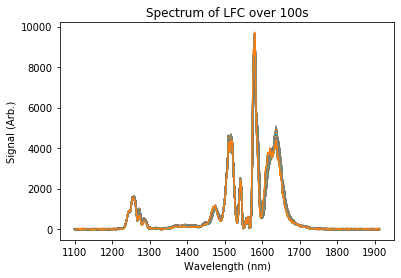

In [4]:
"""-------Linear scale plots---------"""
fig1 = plt.figure()
for i in range(dy):
    plt.plot(wavelength,data[i])
    
plt.title('Spectrum of LFC over 100s')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Signal (Arb.)')
plt.show()
#fig1.savefig('All_cube_log.png', bbox_inches='tight', dpi=300)

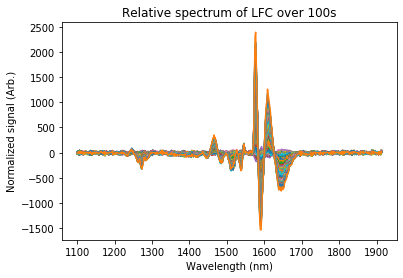

In [5]:
fig2 = plt.figure()
for k in range(dy):
    plt.plot(wavelength,Diff[k])
    
plt.title('Relative spectrum of LFC over 100s')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized signal (Arb.)')
plt.show()
#fig1.savefig('All_cube_log.png', bbox_inches='tight', dpi=300)

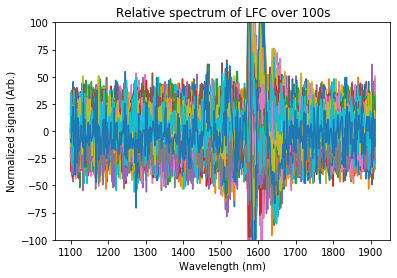

In [13]:
fig3 = plt.figure()
for k in range(1, dy):
    plt.plot(wavelength, data[k]-data[k-1])
    
plt.title('Relative spectrum of LFC over 100s')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized signal (Arb.)')
plt.ylim(-100, 100)
plt.show()
#fig1.savefig('All_cube_log.png', bbox_inches='tight', dpi=300)

# Is it a random walk?
At any given wavelength, what is the distribution of the temporal variation? (plot a histogram). My question is: Is it a random walk? Or is there a trend in terms of a slow, long-term variation. We need to plot these histograms for fractional variations (i.e. variation divided by the amplitude of the last time). 

In [63]:
import pandas as pd
import matplotlib.backends.backend_pdf

df = pd.DataFrame(data)
#df.iloc[0,:]  # to access 0th row
#df[0]  # to access 0th column
#df.iloc[:,0] # to access 0th column
x = df.iloc[:,0] # to access 0th column
np.mean(x)

-11.41244117647059

In [65]:
nrow = 7
ncol = 7
f, ax = plt.subplots(nrow, ncol, figsize=(100, 100))


for j in range(0, nrow*ncol):
    for i in range(10*j, 10*(j+1)):
        f_lam = df.iloc[:,i]
        f_lam = np.array(f_lam)
        diff_f_lam = np.diff(f_lam)
        mean_f_lam = np.mean(f_lam)
        if mean_f_lam == 0: mean_f_lam = 1.0
        frac_diff_f_lam = diff_f_lam/np.abs(mean_f_lam)
        plot_row = np.int(j/ncol)
        plot_col = np.int(j%nrow)
        ax[plot_row, plot_col].hist(frac_diff_f_lam, alpha=0.3, label=str(wavelength[i]))
        ax[plot_row, plot_col].legend(fontsize=32)


plt.tight_layout()
plt.show()    
pdf_name = 'Histograms_LFC.pdf'
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_name)
pdf.savefig(f, dpi = 100, bbox_inches='tight')
plt.close()
pdf.close()

# What is the realtive scale of the variation? 
That is, how does the diff/(signal value at that time) vary with time and wavelength. Essentially, the same question as above, but for fractional change (with respect to the last readout and also with respect to the first readout of the data). This is important because the dynamic spectrum flattner (DSF) will impart fractional changes in the amplitude. You can also convert this to dB. This will inform how many dBs of variation is there right now and how much we want to target from the DSF. <br><br>

### Standard deviation of the fractional change (stepwise: 1 sec) vs wavelength
This is the fractional change from previous step. The normalization factor is the mean flux at that wavelength. 

In [159]:
#f_lam_min = 1.0 # This is the minimum level we will assume to avoid -ve numbers. 

def calc_frac_diff_f_lam_std(df, dx, f_lam_min):
    frac_diff_f_lam_std = []
    for i in range(dx):
        f_lam = df.iloc[:,i]
        f_lam = np.array(f_lam)
        f_lam = np.clip(f_lam, f_lam_min, np.inf) # This step is important 
        diff_f_lam = np.diff(f_lam)
        mean_f_lam = np.mean(f_lam)
        if mean_f_lam == 0: mean_f_lam = f_lam_min
        frac_diff_f_lam = diff_f_lam/np.abs(mean_f_lam)
        frac_diff_f_lam_std.append(np.std(frac_diff_f_lam))
    frac_diff_f_lam_std = np.array(frac_diff_f_lam_std)
    return frac_diff_f_lam_std

### ### Standard deviation of the fractional change (wrt mean) vs wavelength

In [160]:
def calc_frac_delta_f_lam_std(df, dx, f_lam_min): 
    frac_delta_f_lam_std = []
    for i in range(dx):
        f_lam = df.iloc[:,i]
        f_lam = np.array(f_lam)
        f_lam = np.clip(f_lam, f_lam_min, np.inf) # This step is important
        mean_f_lam = np.mean(f_lam)
        if mean_f_lam == 0: mean_f_lam = f_lam_min
        delta_f_lam = f_lam - mean_f_lam
        frac_delta_f_lam = delta_f_lam/np.abs(mean_f_lam)
        frac_delta_f_lam_std.append(np.std(frac_delta_f_lam))
    frac_delta_f_lam_std = np.array(frac_delta_f_lam_std)
        
    return frac_delta_f_lam_std

In [186]:
def plot_frac_diff_f_lam_std(wavelength, data, dy, frac_diff_f_lam_std, title):
    figure()
    plt.plot(wavelength, frac_diff_f_lam_std)
    for i in range(dy):
        plt.plot(wavelength,data[i]/1000)

    plt.title('Standard deviation of the fractional change over 100s' + str(title))
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Std. dev. of frac. change' + str(title))
    plt.ylim(-1, np.max(frac_diff_f_lam_std))    
    return None

### Converting it to dB-scale

In [187]:
def plot_frac_diff_dB(wavelength, data, dy, frac_diff_f_lam_std, title):
    figure()
    plt.plot(wavelength, 10*np.log10(frac_diff_f_lam_std))
    for i in range(dy):
        plt.plot(wavelength, np.log10(data[i]))

    plt.axhline(y=5, color='k', ls='dashed', alpha=0.5)
    plt.axhline(y=25, color='k', ls='dashed', alpha=0.5)
    
    
    plt.title('Standard deviation of the fractional change over 100s' + str(title))
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Std. dev. of frac. change'  + str(title))
    plt.ylim(-10, 30)
    
    return None

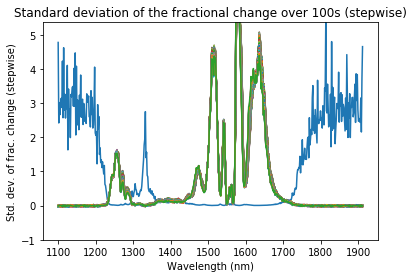

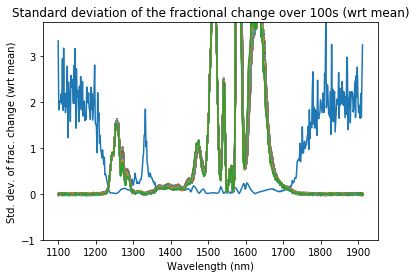

In [191]:
f_lam_min = 0.1
frac_diff_f_lam_std = calc_frac_diff_f_lam_std(df, dx, f_lam_min)
frac_delta_f_lam_std = calc_frac_delta_f_lam_std(df, dx, f_lam_min)
plot_frac_diff_f_lam_std(wavelength, data, dy, frac_diff_f_lam_std, ' (stepwise)')
plot_frac_diff_f_lam_std(wavelength, data, dy, frac_delta_f_lam_std, ' (wrt mean)')
plt.show()


### Converting it to dB-scale

/home/pradip/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/home/pradip/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


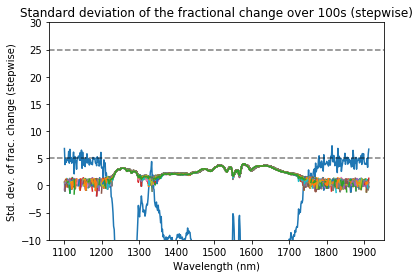

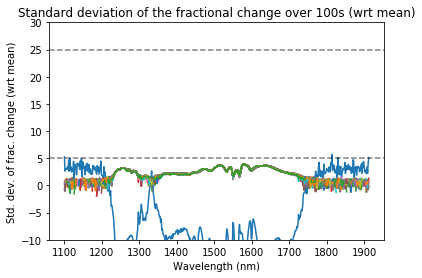

In [192]:
plot_frac_diff_dB(wavelength, data, dy, frac_diff_f_lam_std, ' (stepwise)')
plot_frac_diff_dB(wavelength, data, dy, frac_delta_f_lam_std, ' (wrt mean)')
plt.show()

## Conclusion: 
The low-SNR region is where most of the fluctuation come from. The high-SNR region has minimal fluctuation.

## What box-size is good to maintain a low level of fluctuations ?
### Normalizing wrt mean and thresholding over the average level of a box

In [ ]:
# Clip the mean and the data
# Divide by the mean
# Thresholding: If the (dB-level in the box at time t) > mean(dB-level in the box at time t) + 5 
# then reduce the entire box by upto 10 dB (as needed)
# Now compare the final result with initial result to see if we solved the problem, 
# or created new problems by losing information

## What is the smallest timescale for the fluctuations and hence, what should be the response time of corrections ?

# What is the flux level? 
<b> 
The -ve values are perhaps coming from subtraction from a value. What is the DC level? If the DC level is very high, then the relative fraction is small. Basically, it is important to find out the relative attentuation of the amplitude that we might need. 
</b>

# Long-term vs short-term variations
The deviation with respect to the first readout will give us how much total deviation is happening right now. However, in terms of active control, the quantity that would be important for us is the short-term differential rather than the long-term variation. Think about this as a PID controller. As we deviate from the desired level, we will immediately apply correction (through active path delays) and the amplitude will start to show the intended correction. <br><br>
However, the intrinsic long-term variation (say, from the source) might continue to drive the amplitudes in one direction. To determine the limit to which we can control the amplitude variation, it would be nice to look at the fractional variation (in dB) with respect to the first readout (or a reference readout).  

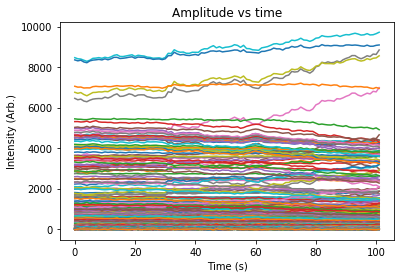

In [5]:
fig11 = plt.figure()
for j in range(dx):
    plt.plot(data[:,j])
    
plt.title('Amplitude vs time')
plt.xlabel('Time (s)')
plt.ylabel('Intensity (Arb.)')
plt.show()
#fig1.savefig('All_cube_log.png', bbox_inches='tight', dpi=300)

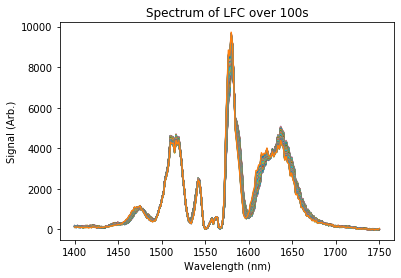

In [6]:
"""-------Linear scale plots, narrower range---------"""
fig3 = plt.figure()
for i in range(dy):
    plt.plot(wavelength[186:408],data[i,186:408])
    
plt.title('Spectrum of LFC over 100s')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Signal (Arb.)')
plt.show()
#fig1.savefig('All_cube_log.png', bbox_inches='tight', dpi=300)

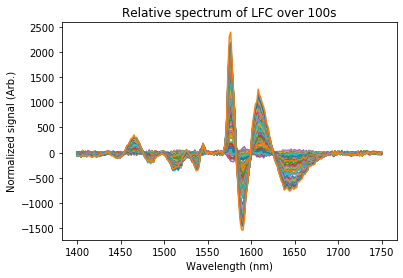

In [7]:
fig4 = plt.figure()
for k in range(dy):
    plt.plot(wavelength[186:408],Diff[k,186:408])
    
plt.title('Relative spectrum of LFC over 100s')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized signal (Arb.)')
plt.show()
#fig1.savefig('All_cube_log.png', bbox_inches='tight', dpi=300)



/home/pradip/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


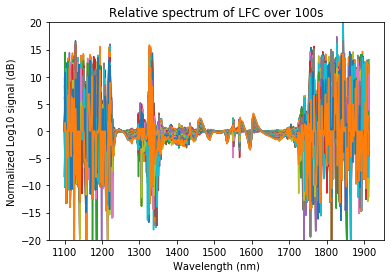

In [8]:
"""-------Log scale plots---------"""
y, x  = np.shape(data)
#LogNorm = np.zeros_like(data)
Maximum = np.max(data[0])

data[data<0]=1**-4

Norm  = data/Maximum

LogNorm = 10*np.log10(Norm)-(10*np.log10(data[0]/Maximum))


fig9 = plt.figure()
for k in range(dy):
    plt.plot(wavelength,LogNorm[k])
    
plt.title('Relative spectrum of LFC over 100s')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Log10 signal (dB)')
plt.ylim(-20,20)
plt.show()
#fig1.savefig('All_cube_log.png', bbox_inches='tight', dpi=300)
